# Decision Tree Classifier

## Purpose of this notebook

In this notebook we will repeat on some processes in the data science life cycle like

- selection of an evaluation metric
- dealing with imbalanced data
- creating a baseline model
- error analysis


There will be a small excursion on documenting functions.

You will learn how to prevent overfitting with Decision Trees and will get a deeper insight into your model by testing out the feature importance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set random seed to ensure reproducible runs
RSEED = 50

## Dataset

**Behavioral Risk Factor Surveillance System Public health surveys**

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual (good vs. poor health). We have limited the data to 100,000 individuals to speed up training (ca. 1/4 of the whole dataset). When dealing with a large dataset, it's effective to first use a subset of the data to verify that your data pipeline is functioning correctly. This includes steps like data cleaning and feature engineering. Additionally, you can evaluate which models might be promising. Once these preliminary steps are complete and you're confident in your approach, you can then use the full dataset to fine-tune your model. This strategy can save both time and costs, as you can perform the initial steps on your local computer before transitioning to cloud resources. 


The objective of the BRFSS is to collect uniform, state-specific data on preventive health practices and risk
behaviors that are linked to chronic diseases, injuries, and preventable infectious diseases in the adult population.
Factors assessed by the BRFSS include tobacco use, health care coverage, HIV/AIDS knowledge or prevention,
physical activity, and fruit and vegetable consumption. Data are collected from a random sample of adults (one per
household) through a telephone survey.

If you want to have a look at the whole data, it's available on [kaggle](https://www.kaggle.com/datasets/ariaxiong/behavioral-risk-factor-surveillance-system-2022/data).

You can find a description of all the columns (there are many) in the [code book report](LLCP_2022_Codebook_Report.pdf).

In [56]:
df = pd.read_csv('data/brfss2022-100000-samples.csv', dtype="float32")

In [57]:
# Create labels, persons health status
df = df.loc[df['_RFHLTH'].isin([1, 2])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
value_counts = df['label'].value_counts()

df['label'] = df['label'].map({1:'Good Health' , 2: 'Poor Health'})

Below, we drop a number of columns that we should not use for modeling (they are different versions of the labels, or don't contain any data, or are considered meta data).

In [77]:
df.columns

Index(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'CTELENM1',
       ...
       '_SMOKGRP', '_LCSREC', 'DRNKANY6', 'DROCDY4_', '_RFBING6', '_DRNKWK2',
       '_RFDRHV8', '_FLSHOT7', '_PNEUMO3', '_AIDTST4'],
      dtype='object', length=309)

In [ ]:
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'MENTHLTH',"_PHYS14D","_MENT14D", "WORKCFS", "HAVECFS","TOLDCFS" ])
meta_data_col = ["_PRACE2", "_MRACE2", "_HISPANC", "_RACE1", "_RACEG22", "_RACEGR4", "_RACEPR1", "_IMPRACE"]
meta_data = df[meta_data_col]
df = df.drop(columns= meta_data_col)




KeyError: "['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'MENTHLTH', '_PHYS14D', '_MENT14D', 'WORKCFS', 'HAVECFS', 'TOLDCFS'] not found in axis"

In [60]:
cols_to_drop = ['POORHLTH','PHYSHLTH','GENHLTH','MENTHLTH','_PHYS14D','_MENT14D','WORKCFS','HAVECFS','TOLDCFS']
df = df.drop(columns=cols_to_drop, errors='ignore')


In [61]:
df.columns

Index(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'CTELENM1',
       ...
       '_SMOKGRP', '_LCSREC', 'DRNKANY6', 'DROCDY4_', '_RFBING6', '_DRNKWK2',
       '_RFDRHV8', '_FLSHOT7', '_PNEUMO3', '_AIDTST4'],
      dtype='object', length=309)

## EDA



### Label Distribution

To better understand the data, let's examine the label distribution. This will influence some decisions we have to make later. Since plotting is not the focus of this notebook, the plotting function is hidden in the `helper_and_plotting_functions.py` file. If you want to understand what this function does, you can use the help function to print its docstring. Docstrings serve as documentation, helping others understand what your function does, the input variables, and the output. You might also want to add an example to show how your function works more clearly.

In [11]:
from helper_and_plotting_functions import plot_label_distribution

In [12]:
help(plot_label_distribution)

Help on function plot_label_distribution in module helper_and_plotting_functions:

plot_label_distribution(label_percentages)
    Plotting the distribution of the health status of participants.
    
    Args:
        label_percentages (Series): percentages for people
                                    with good vs poor health.



In [15]:
# Calculate the value counts of the 'label' column
value_counts = df['label'].value_counts()
print (value_counts)

# Convert the counts to percentages
percentages = (value_counts / value_counts.sum()) * 100
print (percentages)


label
Good Health    81734
Poor Health    18266
Name: count, dtype: int64
label
Good Health    81.734
Poor Health    18.266
Name: count, dtype: float64


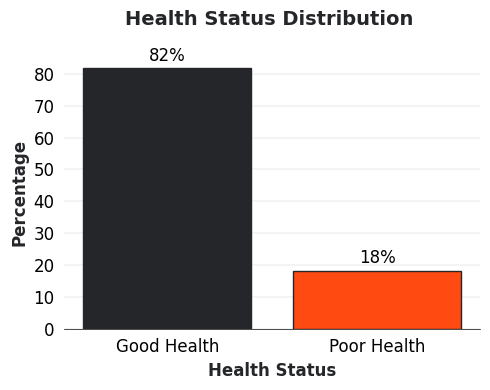

In [16]:
plot_label_distribution(label_percentages=percentages)

We have an imbalanced dataset (far more of one label than the other).

> What do you need to consider when working with an imbalanced dataset? Reflect on the next steps in the data science lifecycle and whether this has any implications for them.

<details><summary>
Click here for some ideas what you need to think of...
</summary>

- Is the imbalanced plausible? Was it expected? Do you think it reflects the whole population well, or is it caused by some selection bias?

- What are the implications for the business case? Which is the class we want to predict? Which is the more critical error: missing a positive case (false negative) or wrongly predicting something as positive (false positive). --> The more important class should be your class 1.

- Which metric should you use? Not all metrics are working well for imbalanced data. Don't use accuracy.

- Make sure the train and test data are good representations of the overall data distribution --> use the "stratify" possibility when running train-test-split.

- You could use some resampling techniques when training your models, to make sure the model can better differentiate the classes.

- Think of using class weights in model training. Increasing the weight for the minority class can help the model pay more attention to it.

-  After modeling you could do threshold tuning: Adjust the decision threshold to improve recall or precision based on your specific needs.
</details>



We won't do any further data exploration in this notebook, but in general, exploring the data is best practice. This can help you gain more knowledge about your data, for feature engineering (which we also won't do here) or by identifying and correcting anomalies / mistakes in the data.

## Deciding on an Evaluation Metric

Now it's time to think of which evaluation metric we use.

<details><summary>
What factors should you consider when choosing an evaluation metric?
</summary>

- of course, if you have balanced or imbalanced data (that's why we checked that early on).

- what's the business scenario in which you create the data product (your model)? In some applications, the cost of false positives and false negatives can differ significantly. This will influence your decision of the evaluation metric.

- is there a typical benchmark metric other people in the field are using? If you want to compare your model with other models, it might be wise to use the same metric.

- Simplicity vs. Complexity: Choose a metric that balances simplicity and the ability to capture the nuances of model performance. Simple metrics might be easier to interpret and communicate to stakeholders, but might not capture all aspects of performance.


</details>
Which metric would you choose and why?
<br><br><br><br><br><br><br>

In the case of the US. Centers for Disease Control and Prevention (CDC), who conducted the survey, they might want to make sure, that they can differentiate the two classes of people with good vs. poor health well. In the medical field, you often have to deal with the trade-off between correctly identifying diseased patients (true positive rate) and incorrectly diagnosing healthy patients (false positive rate). The TPR should be as high as possible while the FPR should be small at the same time. As this might not be possible, Finding a good balance between those, might be preferable. This trade-off is very well displayed in a ROC-curve, where you plot true positive rate over false positive rate for all possible thresholds. To compare models, it is easier to have a single value as evaluation metric. That can be achieved with using the ROC-AUC (area under the ROC curve).

| **Pros**                                             | **Cons**                                                 |
|------------------------------------------------------|----------------------------------------------------------|
| - Handles class imbalance well. | - May not accurately reflect real-world costs of errors, such as the differing impacts of false positives and false negatives. |
| - Widely used in medical diagnostics due to its ability to assess the effectiveness of tests and models across various applications. | - Doesn't provide insight at specific thresholds, which can be crucial in certain applications. |
| - Balances true positive and false positive  rates, offering a balanced assessment of a model's capability. |  - The concept and implications of AUC may not be intuitive for stakeholders. |
| - Offers a single metric (AUC), simplifying model evaluation and comparison across different classifiers. | |

If you want to explain the ROC-AUC in a single sentence, you can give people the probabilistic interpretation:

> The AUC is the probability that the model will rank a randomly chosen positive example more highly than a randomly chosen negative example.

Normally the AUC ranges from 0.5 to 1, with higher numbers indicating better performance. A perfect classifier (no misclassifications) will have an AUC of 1, while 0.5 indicates to a random classifier.

## Split Data into Train and Test Set 

To assess our predictions, we'll need to use a training and a testing set. The model learns from the training data and then makes predictions on the testing data. Since we have the correct answers for the testing data, we can tell how well the model is able to generalize to new data. It's important to only use the testing set once, because this is meant to be an estimate of how well the model will perform on new data. 

We'll save 30% of the examples for testing.

> As our data is unbalanced, we are using the "stratify" option, to make sure each set contains approximately the same percentage of samples of each target class as the complete set.

In [22]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

### Imputation of Missing values

We'll fill in the missing values with the mean of the column. It's important to note that we fill in missing values in the test set with the mean of columns in the training data. This is necessary because if we get new data, we'll have to use the training data to fill in any missing values. 

In [23]:
train = train.fillna(train.mean())
test = test.fillna(train.mean())

# Features for feature importance
features = list(train.columns)

 <details><summary>
Why should you impute missing values only after you have split the data into train and test?
</summary>

- Otherwise, you would use some information from the test set (here: the mean of the whole set) in the training phase. This is called "Data leakage". It can result in overly optimistic performance estimates (the performance on the test set will be higher than in production, when you use then the first time really unseen data.)
<summary>



<details><summary>
Do you remember why it is important to fill missing values in the training and in the test data with the mean of the training data? (Instead of filling the missing values in the test data with the mean of the test data.)
</summary>

When you are setting up your data cleaning, feature engineering, and modeling processes, keep in mind that your goal is to use it in production, when you have a single data point to predict. If your pipeline can't handle this scenario, you need a different approach. For a single data point with a missing value, you can't calculate a new mean. Therefore, the approach should be to use the mean from the training data, which represents the population best. The training data mean is the best estimate since we assume it's an unbiased sample of the population. Test data is used to evaluate how the model would perform in production, so we should treat it as if it were in production. Even if we could use the mean of the test set (as we have more than one data point in the test set), the training set will have more data points and therefore a more robust value for the mean.
<summary>

## Baseline Model

Before we are starting with machine learning modeling, we should create a baseline model. 

 <details><summary>
Why do we need a baseline model?
</summary>

- It ensures that the development of more sophisticated models is justified, provides a clear point of comparison, and helps to validate the effectiveness and efficiency of advanced modeling efforts.
 </details>

Here are some thoughts on how to decide which model you should use as baseline:

- Your company already has a model (doesn't have to be a ML model) in place, you want to find out how to improve it. The existing model can be your baseline model.
- For the explicit problem you are trying to tackle, other people decided on a typical baseline model, which is used to compare all results against. That would be also the baseline model you would prefer.
- There is nothing existing to compare your model against, then create your own. You want to make it simple and easy for other people to understand. It should also make some sense, therefore, you should use your business understanding or your findings from the EDA to create it.
- If you have to create the baseline model yourself, you can choose to take a simple heuristic, showcasing that using more complex machine learning models have a benefit solving the task.

In our case, as we didn't do an EDA on our data (which would have been best practice, and definitely better than what we are doing now), we can do a quick search online what might be driving factors of poor health, based on some personal information. A short internet search (this is all the time we will spent on business understanding 🙈) showed, that there might be a relationship between age, poverty and health status of people. [This was shown in the UK](https://www.health.org.uk/evidence-hub/money-and-resources/poverty/relationship-between-poverty-age-and-health#:~:text=The%20difference%20in%20the%20share,(both%2016%20percentage%20points).), most probably we can also see it in our data in the US. 

First we need to define what the poverty level is. The [federal poverty level](https://www.healthcare.gov/glossary/federal-poverty-level-fpl/) is published for the US every year. The [normal household size in US](https://www.pewresearch.org/short-reads/2019/10/01/the-number-of-people-in-the-average-u-s-household-is-going-up-for-the-first-time-in-over-160-years/#:~:text=Note%3A%20There%20are%20two%20ways,a%20household%20with%203.4%20people.) is ca. 3 people, therefore, we will simply define a threshold below which people are considered poor on the basis of their annual income. A household with an annual income of less than 25,000 dollars is considered poor, otherwise not.

Let's produce the same plot as in the link, but this time with our data. As this is not the focus of the notebook, the plotting function is hidden in the helper_and_plotting_functions.py.

In [24]:
from helper_and_plotting_functions import plot_income_health

In [25]:
train_with_y = train[["_AGEG5YR", "INCOME3"]].copy()
train_with_y["label"] = train_labels
train_with_y["_AGEG5YR"] = train_with_y["_AGEG5YR"].astype("int")
train_with_y["INCOME3"] = train_with_y["INCOME3"].astype("int")

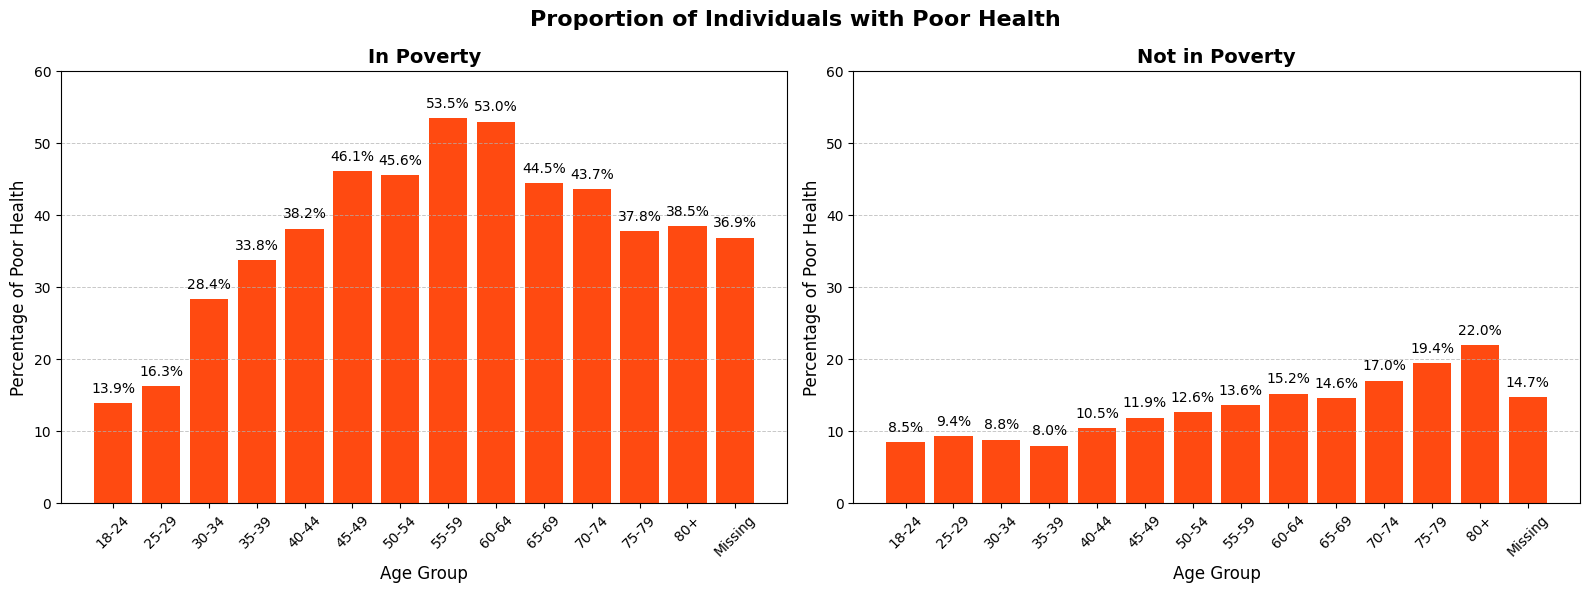

In [26]:
# Create subplots for each income level
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for income level 1 and income levels not equal to 1
for i, poverty in enumerate([True, False]):
    plot_income_health(train_with_y, poverty, axs[i])

# Set a single main title for both plots
fig.suptitle('Proportion of Individuals with Poor Health', fontsize=16, weight='bold')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

As shown by "The health foundation" and in our dataset, people living in poverty and are older than 54 years old, have a higher risk for having poor health. We will use exactly this information for our baseline model:
- predicting everyone older than 54 and living in poverty as having poor health
- predicting everyone else as having good health.

This is a very simplification of the health status of people, but both features might really influence the target. Therfore, our baseline model is easy to explain to people, we can argue why those might be two important features for prediction and we can use this simple heuristic approach to show how much machine learning can do better than that.

Let's finally create our baseline model!

In [66]:
def baseline_model(row):
    """Rule-based baseline classifier for health status.

    Returns "Poor Health" when age bucket is 8-13 and income <= 4;
    otherwise returns "Good Health". Expects row to contain
    "_AGEG5YR" and "INCOME3".
    """
    age_bucket = row['_AGEG5YR']
    income = row['INCOME3']
    
    if 8<= age_bucket <= 13 and income <= 4:
        return 'Poor Health'
    else:
        return 'Good Health'

# Apply baseline model to each row in the DataFrame
y_pred_baseline = test.apply(baseline_model, axis=1)
y_pred_prob_bl = np.where(np.array(y_pred_baseline)=='Good Health', 0, 1)

## Excursion: Docstrings

In general, docstrings serve as inline documentation for functions, classes, modules, and packages (describing what a piece of code does, its parameters, return values, any exceptions, etc.) without having to read the code itself.

This might be especially useful later when you work with large codebases or when reviewing unfamiliar code.

Python's built-in `help()` function and various IDEs and development tools can use docstrings to provide contextual help and code introspection. This allows developers to quickly access information about function signatures, parameters, and usage.

Using docstrings is good practice for promoting code readability, facilitating collaboration among developers (including your future self), and enabling tools for code introspection and automated documentation generation.

#### \"autoDocstring\" VSCode extension:


In the beginning of the bootcamp during setting up your machines, the \"autoDocstring\" extension for VSCode was installed (if not you can search for it and install it now). The extension can facilitate and standardize writing docstrings for your code:

1. **Checking docstrings:** In VS Code, you can use the built-in code suggestions feature to view docstrings of functions, methods, and classes. Simply place the cursor on the function or class name, press `Ctrl + Space`, and you'll see a tooltip with the docstring information if it's available.

2. **Writing docstrings with autoDocstring extension:** The \"autoDocstring\" extension for VS Code helps you generate docstrings quickly and efficiently by typing `"""` or `'''` (triple quotes) and pressing Enter. It will generate a template docstring with placeholders for parameters, return values, and other relevant information. You can then fill in the details accordingly. Pressing `tab` will guide you to the next part of the docstring where your individual input is needed.

When writing docstrings, it's good practice to follow the Python docstring conventions outlined in [PEP 257](https://www.python.org/dev/peps/pep-0257/). This includes using triple quotes (`"""`) for multi-line docstrings, using the appropriate sections (e.g., Parameters, Returns, Raises) to describe function behaviour, and adhering to a consistent style within your codebase.

> Write a docstring for the function "baseline_model", and try to use the help(function). (If you are too lazy to write it yourself, you can also ask chatgpt, but be aware, that it has not all the background information to give you a 100 % correct answer.)

<details><summary>
Here is an example of the docstring.
</summary>

    """Baseline model predicts people older than 54 and living in poverty (less than 25 000$ per year) as having poor health.

    Args:
        row (DataFrame row): one row of a DataFrame

    Returns:
        string: prediction label ("Poor Health" or "Good Health").
    """

<summary>
    

## Predictive Modeling

Now we can train a decision tree on the data. Let's leave the depth unlimited and see if we get overfitting! 

In [67]:
# Train tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=RSEED)
tree.fit(train, train_labels)

DecisionTreeClassifier(random_state=50)

In [68]:
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')
print(f'On average there are ca. {train.shape[0]/tree.tree_.node_count:.1f} data points in each leaf.')

Decision tree has 13661 nodes with maximum depth 71.
On average there are ca. 5.1 data points in each leaf.


A very deep tree with many leaves often indicates overfitting, as it can capture noise and details specific to the training data rather than general patterns.

<details><summary>
Do you think this tree is overfitting? How could we figure out if the model is overfitting?
</summary>

To evaluate if a decision tree is overfitting, you can use the following methods:

1. Train-Test Split Performance: Compare the model's performance on the training set and a separate test set. If the model performs significantly better on the training set than on the test set, it is likely overfitting.

2. Cross-Validation: Use cross-validation to assess the model's performance on multiple subsets of the data. If the model shows high variance in performance across different folds, it indicates overfitting.

<summary>

### Assess Decision Tree Performance


Given the number of nodes in our decision tree and the maximum depth, we expect that it has fitted the training data too well. This means it will do much better on the training data than on the testing data.

Let's have a look at our performance metric, the ROC AUC.
To calculate it, we need to get the predicted probabilities for each data point.


<details><summary>
How are those predicted probabilities calculated for the decision tree?
</summary>

To predict classes, the decision tree will use the majority vote in the respective leaf the data point belongs to. 

The predicted class probability is the fraction of samples of the same class in a leaf.

<summary>

<details><summary>
Which different pobabilities do you expect for this specific tree?
</summary>

This is a full grown tree. It could happen that all the leaves are pure. Therefore, there might be just probabilities, that are 0 or 1. If you want, you can validate this result with code :) 

<summary>

In [69]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [70]:
from sklearn.metrics import roc_auc_score

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {round(roc_auc_score(test_labels, probs),2)}')
print(f'Baseline ROC AUC  Score on test data: {round(roc_auc_score(test_labels, y_pred_prob_bl),2)}')
print(f'Random Guess ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.66
Baseline ROC AUC  Score on test data: 0.57
Random Guess ROC AUC: 0.5


We can see that our model severely overfits the training data, achieving perfect ROC AUC on the training data, while having a much lower score on the test data. But it is better than random guessing and also better than our baseline model, indicating that the features have some predictive power on the health state of the survey participants, and that the ML approach gives use even better results than our small heuristic.



## Error analysis

We are using error analysis after creating a model, to figure out where our model has problems. Either to find solutions to fix it, or to find situations where the model might not be a good choice to use it.

When you use the ROC AUC as a metric, it is good to also have a look at the ROC Curve for comparing models. You should also have a deeper look at the errors. A good starting point for this is the confusion matrix.

In [64]:
from helper_and_plotting_functions import evaluate_model

Recall 

for Baseline: 0.19, Model on Test: 0.45  and on Train: 1.0
---------------------------------------------
Precision 

for Baseline: 0.43, Model on Test: 0.43  and on Train: 1.0
---------------------------------------------
Roc 

for Baseline: 0.57, Model on Test: 0.66  and on Train: 1.0
---------------------------------------------


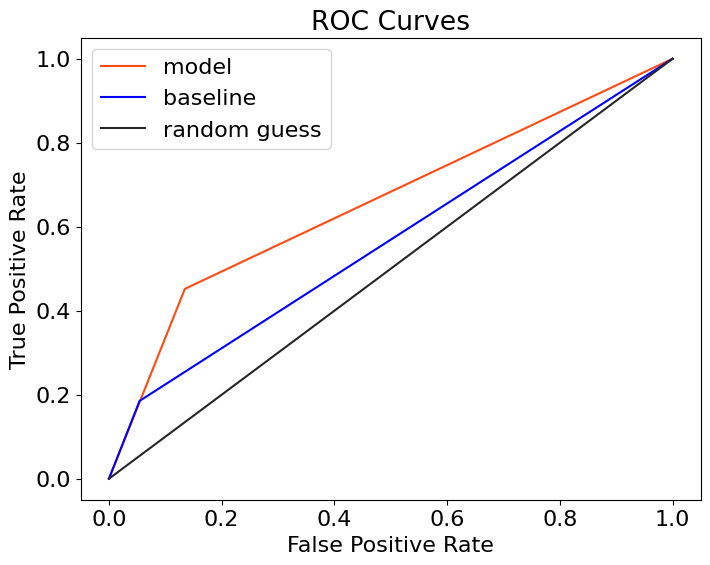

In [71]:
evaluate_model(predictions, probs, np.array(y_pred_baseline), train_predictions, train_probs, train_labels, test_labels)

This ROC-Curve doesn't really look like a curve, neither for the baseline model, nor for the decision tree model. They rather display one combination of FPR and TPR that is connected by a straight line with the two points (1,1) and (0,0).

<details><summary>
Why do you think that's the case? Having a look at the calculated fpr and tpr for different thresholds might be helpful. See the commented out cell below.
</summary>

As mentioned before, this full grown tree does not have other probabilities than 0 and 1, because all the leaves are pure. Therefore, we have 3 possible cases for different thresholds, that are displayed here in the plot:
1. we predict everything as class 0, doesn't matter what the model is giving us --> (0,0) (threshold=0)
2. we have a threshold between 0 and 1, we predict 0, if the model says probability is 0, and 1 if the model says probability of 1. --> (the middle point) (threshold < 1)
3. we predict everything as class 1, doesn't matter what the model is giving us --> (1,1) (threshold > 1)

Having a model that has not only pure leaves, will also give us a ROC AUC curve, that looks like a curve and not like a triangle.

<summary>

In [21]:
#from sklearn.metrics import roc_curve
#model_fpr, model_tpr, thresholds = roc_curve(test_labels, probs, pos_label='Poor Health')

In [72]:
from sklearn.metrics import confusion_matrix
from helper_and_plotting_functions import plot_confusion_matrix

Confusion matrix, without normalization


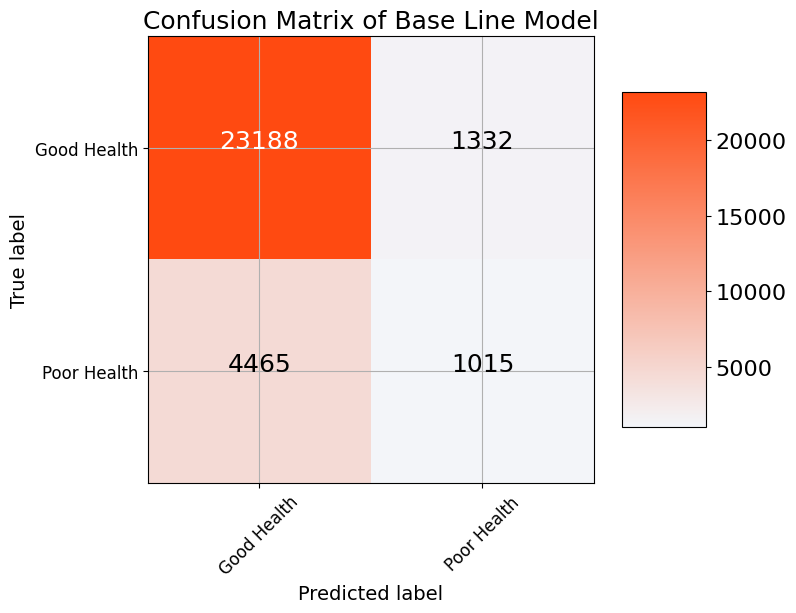

In [73]:
cm = confusion_matrix(test_labels, y_pred_baseline)
plot_confusion_matrix(cm, classes=['Good Health', 'Poor Health'],title="Confusion Matrix of Base Line Model")

Confusion matrix, without normalization


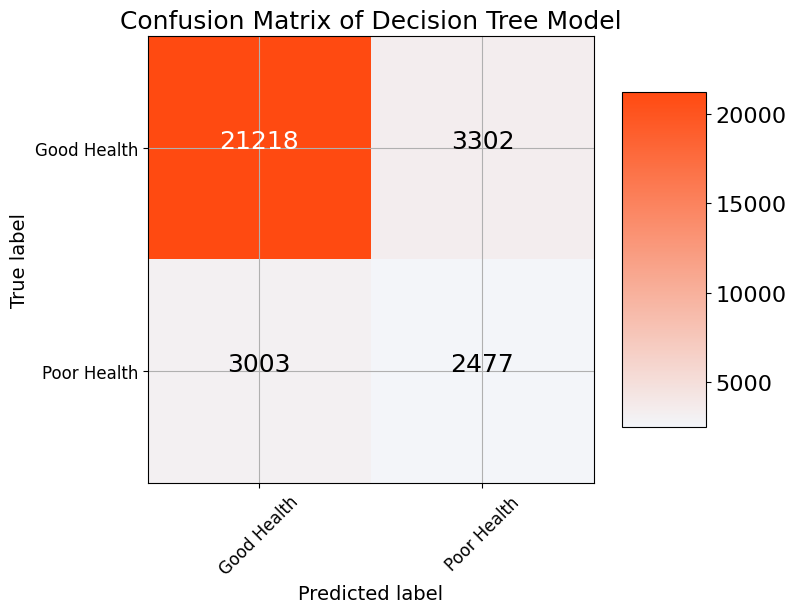

In [24]:

cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes=['Good Health', 'Poor Health'],title="Confusion Matrix of Decision Tree Model")

You can see that the baseline model just figured out 668 of more than 5000 people with poor health conditions, therefore, the recall was pretty low. The decision tree is already doing way better, with 2420 true positives. While the base line model has way more FN that FP, for the  decision tree those numbers are pretty equal. The color scheme is showing us again how unbalanced this data is.

Especially for those imbalanced cases it might be good to see how much percentage of the true labels respectively were predicted as negative and positive, you can add `normalize=True`to the plotting function. See how the percentages in each row add up to 100%.

Normalized confusion matrix


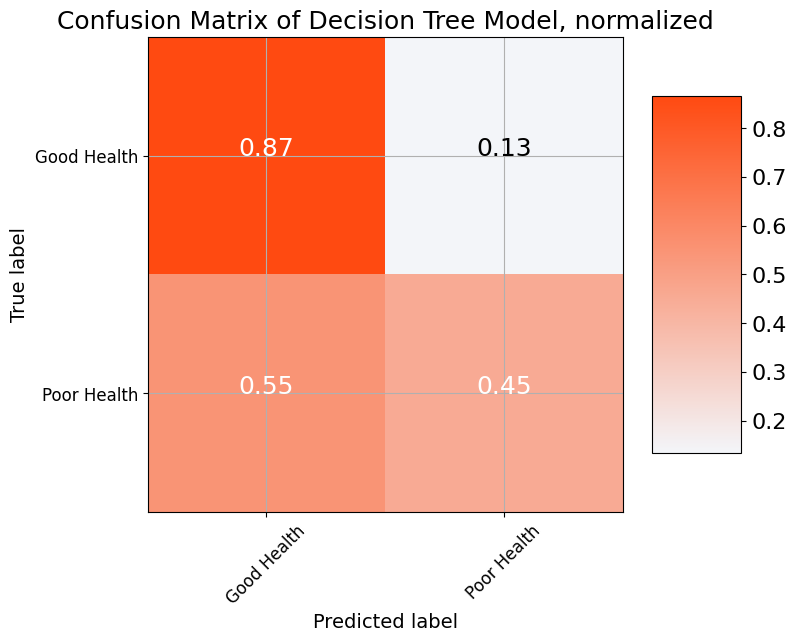

In [74]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes=['Good Health', 'Poor Health'],title="Confusion Matrix of Decision Tree Model, normalized", normalize=True)

### Feature Importance

Have you recognized that the decision tree classifier has an attribute called ["feature_importance_"](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_)?

> "The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance."

To get insights into our model, and which features are most important for it, feature importance might be interesting.It might be useful for:

- Better understanding the data.
- Better understanding a model.
- Reducing the number of input features.

[Source: Machine Learning Mastery](https://machinelearningmastery.com/calculate-feature-importance-with-python/)

Let's have a look at it for our model.

In [75]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
69,DIFFWALK,0.168730
60,EMPLOY1,0.022320
273,_BMI5,0.021635
51,DIABETE4,0.020481
71,DIFFALON,0.018285


The 5 most important features **for our model** are:

- DIFFWALK: Difficulty Walking or Climbing Stairs
- EMPLOY1: Employment Status
- DIABETE4: (Ever told) you had diabetes
- _BMI5: Computed body mass index
- DIRRALONE: Difficulty Doing Errands Alone




The feature importance for the model is calculated by examining all the splits in the tree and determining how much each feature reduces the criterion. In the tree below (we've only shown the first four splits to keep it readable), the first split is on the feature X[69], called "DIFFWALK." This feature might appear in other splits as well. The importance of a feature is the sum of all its criterion reductions. For example, the second most important feature, X[60], is used twice in the first three levels and once more in the fourth level.

Btw. if you look at the first 7 important features, you will also find IDATE and IDAY, informations on which date / day the interview was conducted. Do you think this should have an effect on the health status of a person? Do you consider this feature relevant? Our model does.

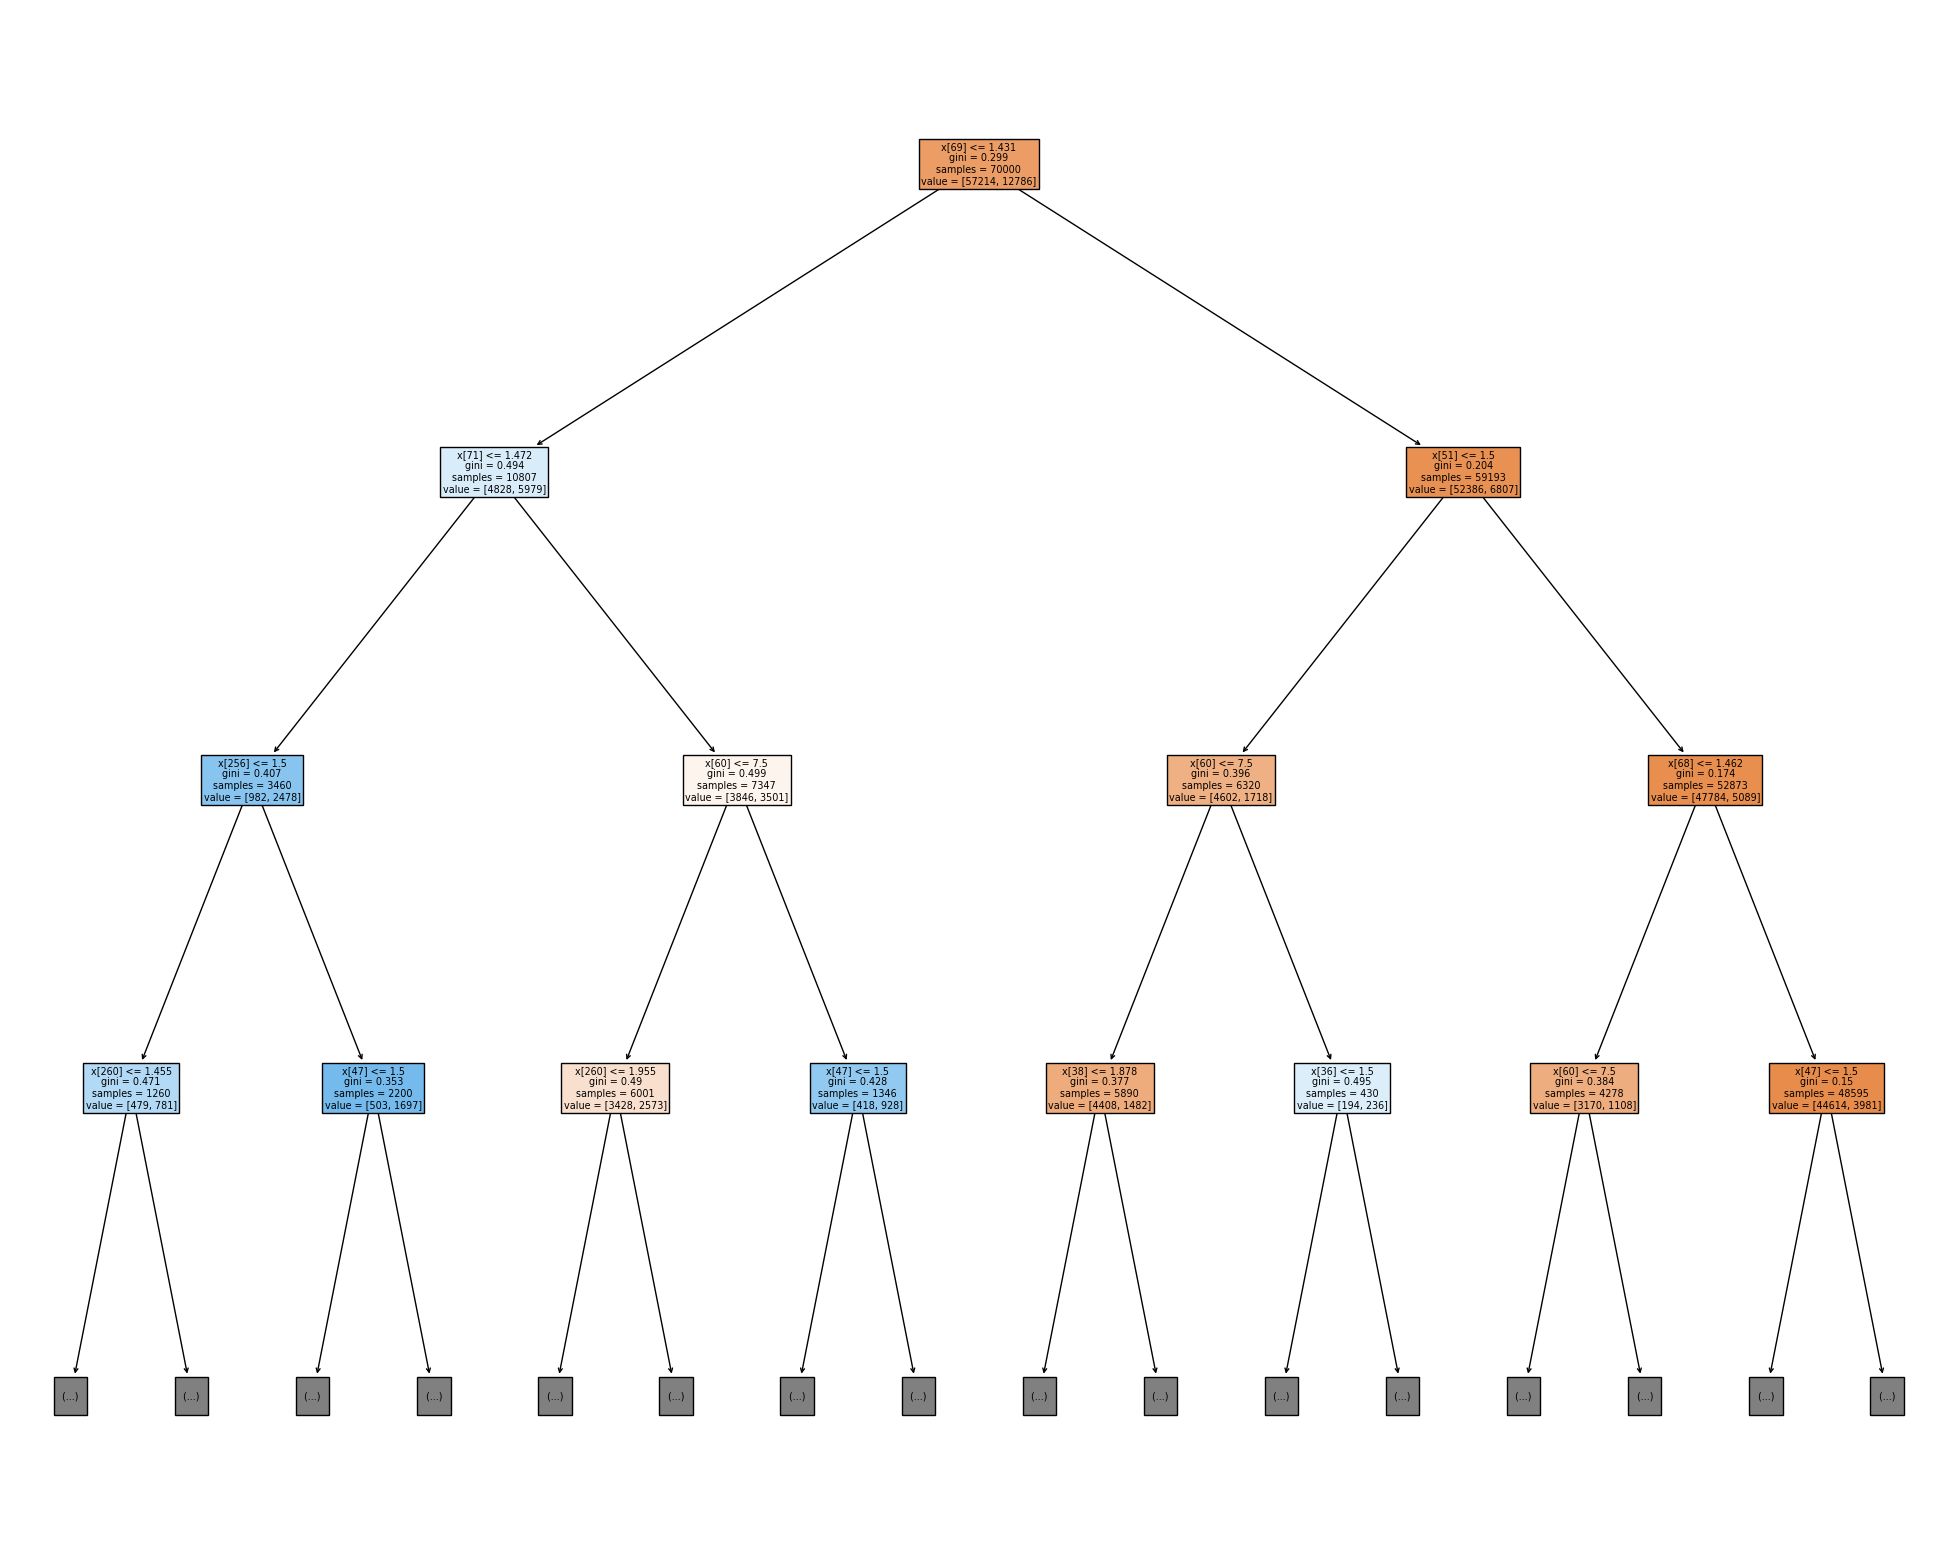

In [78]:
# import necessary library  
from sklearn.tree import plot_tree
fig= plt.figure(figsize=(25,20))
dectree_plot = plot_tree(tree, max_depth=3, filled=True)

We have not had a look at all the data collected by the survey. But, of all the questions about health you could ask people, would you have thought that those questions will have the biggest impact in figuring out if a person has good or poor health? 

Asking this question is very important. Remember the "hypothesis generation". Being aware of our prior knowledge and what we assume should happen and how things are related to one another, can be used as a sanity check on the model. BMI, Diabetes, being able to walk the stairs might be directly related to the health condition. But how can your employment status be related to health? What can you learn from it? 

As mentioned earlier, we can use the results for another round of EDA, focusing on these most important features. And checking how the employment status is related to health. To **better understand the data**.

We can use it to explain to people what are the driving factors why the model is making these predictions, through this, we get a **better understanding of our model**. And we could also reduce the complexity of our model by **reducing the numbers of input features**, checking those features with the least impact on our model.

### Meta data analysis

Evaluating model bias using metadata about user attributes is crucial to ensure fairness and equity in AI systems, as biased models can perpetuate and amplify existing societal inequalities. This evaluation helps in identifying and mitigating unintended discrimination, thereby increasing trust and acceptance of AI technologies. Ultimately, addressing bias fosters ethical AI development, ensuring that models provide fair and accurate outcomes for all user groups.

At the very beginning of the notebook, we removed some meta-data about the people, all about the race. Now we can use this data, that was not used in training, to evaluate if our model is similarly good on the different races presented.

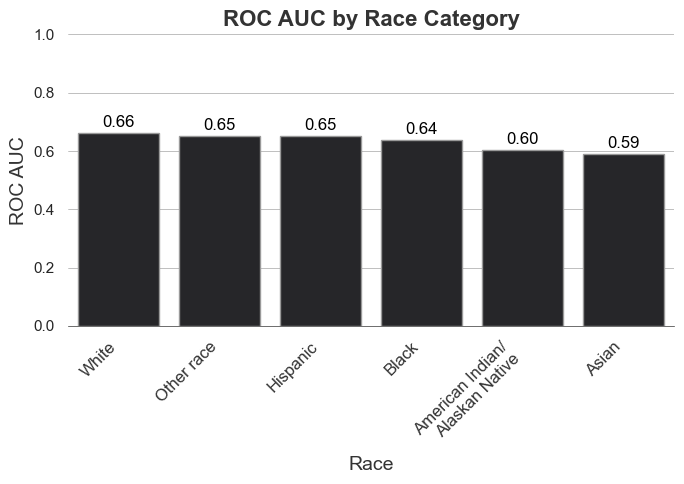

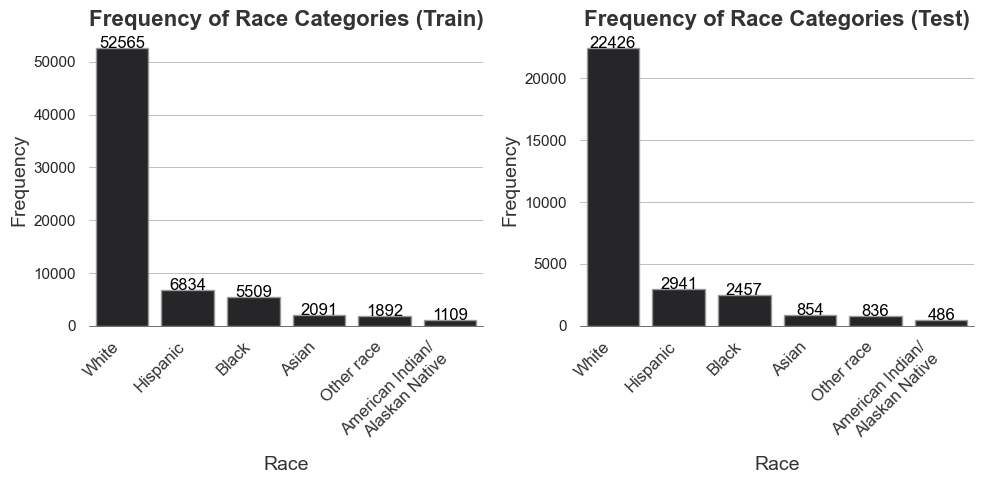

In [79]:
from helper_and_plotting_functions import meta_data_race_analysis

meta_data_race_analysis(test_data=test, test_labels=test_labels, test_predictions=predictions, train_data=train, train_labels=train_labels, train_predictions=train_predictions, meta_data=meta_data)

You see, that our best metric is the highest for White people. The ROC-AUC for Asian and American Indian/ Alaskan Native is the worst. There might be many reasons for this. If we also look at the frequency of those subgroups, you can see that major group in this survey are White. Many data points on that specific group, might help the model to get better in correctly predicting on this subgroup. While it is harder, if the model cannot see many data points of a subgroup. Being aware if the data is a good representation of the whole population is important, as this might lead to a more balanced survey collection next year.

Here is an article, if you want to know more about [analyzing fairness in ML](https://towardsdatascience.com/analysing-fairness-in-machine-learning-with-python-96a9ab0d0705).

## Improve our model

Our model might not be the best we can have.

Now it's up to you to find a better decision tree model. Remember, we figured out two problems with the model/data: Our model is overfitting, our data is imbalanced.

Maybe you find some hyperparameters of the decision tree classifier (in the documentation), that can deal with those two situations. 

Feel free to run a grid search for some of the hyperparemeters and plot the ROC curve as well as the confusion matrix for your best model. You can also try out different criterions and check how it influences the decision tree structure.

<details><summary>
If you want a hint on some promissing hyperparameters, click here.
</summary>
 
- prevent overfitting: regularization hyperparameters are: `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_leaf_nodes`, `min_impurity_decrease` etc.

- deal with imbalanced data in the training phase: use the hpyerparameter `class_weight`. It helps address imbalanced datasets by adjusting the algorithm's training process to give more importance to minority class instances. This improves the model's ability to correctly classify rare events or minority classes.
<summary>

### My improved tree model

Define evaluate_classifier() to evaluate and compare models (ROC AUC, recall/precision, ROC curve, confusion matrix)

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay,
    recall_score, precision_score
)

def evaluate_classifier(model, X_train, y_train, X_test, y_test, title="Model"):
    # Probabilities
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs  = model.predict_proba(X_test)[:, 1]

    # Predictions (threshold 0.5)
    train_pred = model.predict(X_train)
    test_pred  = model.predict(X_test)

    # Convert string labels to binary for ROC/AUC (robust)
    y_train_bin = (y_train == "Poor Health").astype(int)
    y_test_bin  = (y_test  == "Poor Health").astype(int)

    # Metrics (explicit positive label for string targets)
    metrics = {
        "Train ROC AUC": roc_auc_score(y_train_bin, train_probs),
        "Test  ROC AUC": roc_auc_score(y_test_bin,  test_probs),

        "Train Recall": recall_score(y_train, train_pred, pos_label="Poor Health"),
        "Test  Recall": recall_score(y_test,  test_pred,  pos_label="Poor Health"),

        "Train Precision": precision_score(y_train, train_pred, pos_label="Poor Health", zero_division=0),
        "Test  Precision": precision_score(y_test,  test_pred,  pos_label="Poor Health", zero_division=0),
    }

    print(f"\n=== {title} ===")
    for k, v in metrics.items():
        print(f"{k}: {v:.3f}")

    # ROC curve (use binary labels)
    fpr, tpr, _ = roc_curve(y_test_bin, test_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"ROC Curve (Test) — {title}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_test, test_pred, labels=["Good Health", "Poor Health"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good Health", "Poor Health"])
    disp.plot()
    plt.title(f"Confusion Matrix (Test) — {title}")
    plt.show()

    return metrics


Train and compare models (same dataset/features, same algorithm, different hyperparameters)


=== Overfit Tree (no regularization) ===
Train ROC AUC: 1.000
Test  ROC AUC: 0.659
Train Recall: 1.000
Test  Recall: 0.452
Train Precision: 1.000
Test  Precision: 0.429


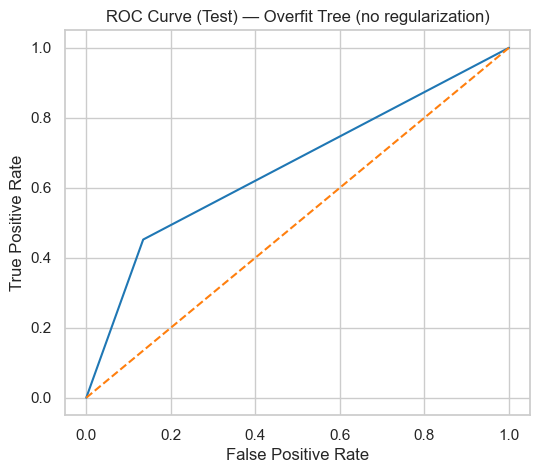

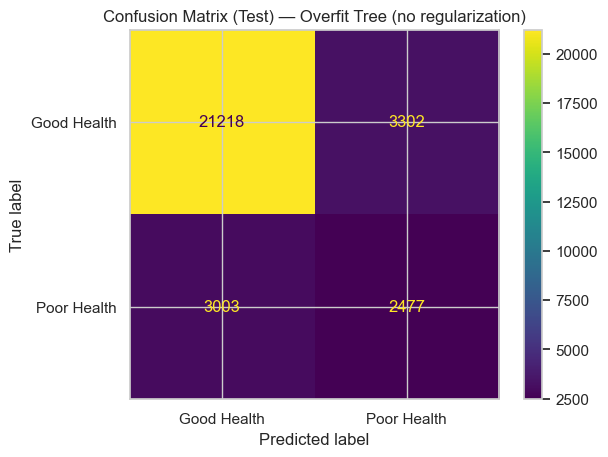


=== Improved Tree (regularized + balanced) ===
Train ROC AUC: 0.820
Test  ROC AUC: 0.812
Train Recall: 0.735
Test  Recall: 0.726
Train Precision: 0.417
Test  Precision: 0.409


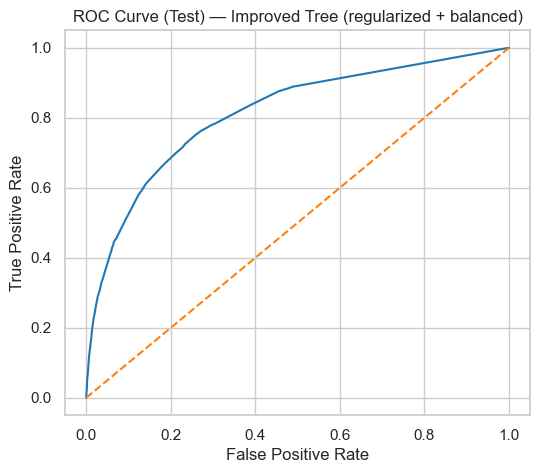

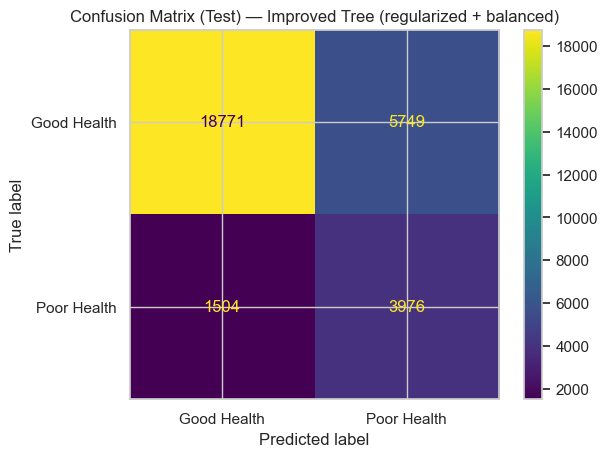

{'Train ROC AUC': 0.8199187454876931,
 'Test  ROC AUC': 0.8122493331825056,
 'Train Recall': 0.7350226810574065,
 'Test  Recall': 0.7255474452554744,
 'Train Precision': 0.4165964803404406,
 'Test  Precision': 0.4088431876606684}

In [93]:
# -----------------------
# 1) Baseline overfit tree (your current one, for comparison)
# -----------------------
tree_overfit = DecisionTreeClassifier(random_state=RSEED)
tree_overfit.fit(train, train_labels)

evaluate_classifier(
    tree_overfit,
    train, train_labels,
    test, test_labels,
    title="Overfit Tree (no regularization)"
)


# -----------------------
# 2) Improved tree: regularization + class_weight (Step 1 + Step 2 together)
# -----------------------
tree_improved = DecisionTreeClassifier(
    random_state=RSEED,
    max_depth=6, #Forces the model to learn general patterns, not memorized rules
    # Depth ~5–8 is a very common starting range in tabular health data
    min_samples_leaf=100,
    min_samples_split=200,
    #small race subgroups 
    # uneven representation
    #Larger leaves reduce:
    #  * noise 
    #  * subgroup 
    #  * overfitting unstable decisions for minorities
    class_weight="balanced"
    # Strong class imbalance
    # “Poor Health” is the class of interest
    # False negatives are costly
    # What class_weight="balanced" does: Penalizes misclassification of “Poor Health” more
    #Forces the tree to care about minority cases Often increases recall (at the cost of precision)
)
tree_improved.fit(train, train_labels)

evaluate_classifier(
    tree_improved,
    train, train_labels,
    test, test_labels,
    title="Improved Tree (regularized + balanced)"
)